In [23]:
import pandas as pd
import numpy as np

In [3]:
df_ml=pd.read_csv("CleanedDataSet.csv")

In [4]:
df_ml['Profit'] = (df_ml['Price'] * (1 - df_ml['Discount'] / 100)) * df_ml['Units Sold']

In [5]:
df_ml.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality,Month,Profit
0,2022-01-01,S001,P0001,Groceries,North,231,127,55.00,135.47,33.50,20,Rainy,0.0,29.69,Autumn,2022-01,3403.600
1,2022-01-01,S001,P0002,Toys,South,204,150,66.00,144.04,63.01,20,Sunny,0.0,66.16,Autumn,2022-01,7561.200
2,2022-01-01,S001,P0003,Toys,West,102,65,51.00,74.02,27.99,10,Sunny,1.0,31.32,Summer,2022-01,1637.415
3,2022-01-01,S001,P0004,Toys,North,469,61,62.18,62.18,32.72,10,Cloudy,1.0,34.74,Autumn,2022-01,1796.328
4,2022-01-01,S001,P0005,Electronics,East,166,14,135.00,9.26,73.64,0,Sunny,0.0,68.95,Summer,2022-01,1030.960


In [7]:
df_ml['Date'] = pd.to_datetime(df_ml['Date'])
df_ml['Month'] = df_ml['Date'].dt.to_period('M').astype(str)

## XGBoost Model


In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import matplotlib.pyplot as plt


df_ml['Profit'] = (df_ml['Price'] * (1 - df_ml['Discount'] / 100)) * df_ml['Units Sold']

df_ml['Year'] = df_ml['Date'].dt.year
df_ml['Month_Num'] = df_ml['Date'].dt.month
df_ml['Day'] = df_ml['Date'].dt.day
df_ml['DayOfWeek'] = df_ml['Date'].dt.dayofweek
df_ml['DayOfYear'] = df_ml['Date'].dt.dayofyear
df_ml['WeekOfYear'] = df_ml['Date'].dt.isocalendar().week.astype(int)
df_ml['Quarter'] = df_ml['Date'].dt.quarter

# Handle missing values
df_ml.fillna(0, inplace=True)


In [9]:
targets = ['Units Sold', 'Profit']
features = [col for col in df_ml.columns if col not in targets + ['Date', 'Month']]
categorical_features = ['Category', 'Region', 'Weather Condition', 'Holiday/Promotion', 'Year', 'Month_Num', 'DayOfWeek', 'Quarter']
numerical_features = [col for col in features if col not in categorical_features and df_ml[col].dtype in ['int64', 'float64']]

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(df_ml[categorical_features])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_features))

# Create processed DataFrame
df_processed = pd.concat([df_ml[numerical_features], encoded_cat_df, df_ml[targets]], axis=1)
df_processed['Date'] = df_ml['Date']

# Sort by date
df_processed = df_processed.sort_values('Date')

In [10]:

split_index = int(len(df_processed) * 0.8)
train_df = df_processed.iloc[:split_index]
test_df = df_processed.iloc[split_index:]

X_train = train_df.drop(targets + ['Date'], axis=1)
y_train_units = train_df['Units Sold']
y_train_profit = train_df['Profit']
X_test = test_df.drop(targets + ['Date'], axis=1)
y_test_units = test_df['Units Sold']
y_test_profit = test_df['Profit']
test_dates = test_df['Date']

In [11]:

xgb_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1
}

# Units Sold
xgb_model_units = xgb.XGBRegressor(**xgb_params)
xgb_model_units.fit(X_train, y_train_units)
xgb_preds_units = xgb_model_units.predict(X_test)

# Profit
xgb_model_profit = xgb.XGBRegressor(**xgb_params)
xgb_model_profit.fit(X_train, y_train_profit)
xgb_preds_profit = xgb_model_profit.predict(X_test)


--- Untuned XGBoost Evaluation Metrics ---
Units Sold:
  R² Score: 0.99
  MAE: 7.29
  RMSE: 8.51
  MAPE: 136416498592056.2969


d:\Download\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


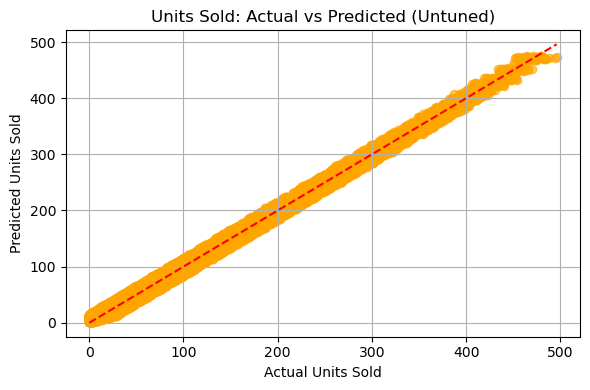

d:\Download\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Profit:
  R² Score: 0.99
  MAE: 380.00
  RMSE: 494.22
  MAPE: 7169747802788800.0000


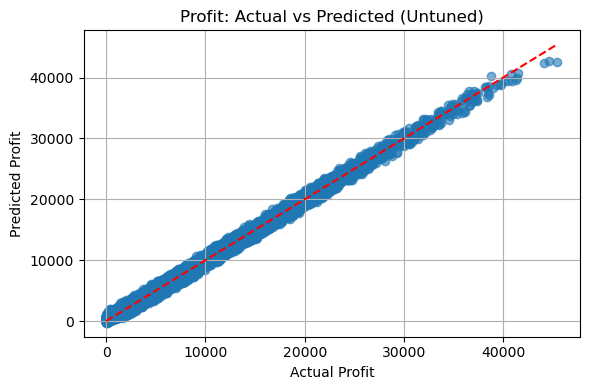

In [27]:
print("\n--- Untuned XGBoost Evaluation Metrics ---")
# Units Sold
r2_units = r2_score(y_test_units, xgb_preds_units)
mae_units = mean_absolute_error(y_test_units, xgb_preds_units)
rmse_units = mean_squared_error(y_test_units, xgb_preds_units, squared=False)  # Corrected to compute RMSE
mape_units = mean_absolute_percentage_error(y_test_units, xgb_preds_units)  # Added MAPE
print("Units Sold:")
print(f"  R² Score: {r2_units:.2f}")
print(f"  MAE: {mae_units:.2f}")
print(f"  RMSE: {rmse_units:.2f}")
print(f"  MAPE: {mape_units:.4f}")

# Scatter plot for Units Sold
plt.figure(figsize=(6, 4))
plt.scatter(y_test_units, xgb_preds_units, alpha=0.6, color='orange')
plt.plot([y_test_units.min(), y_test_units.max()], [y_test_units.min(), y_test_units.max()], 'r--')
plt.xlabel("Actual Units Sold")
plt.ylabel("Predicted Units Sold")
plt.title("Units Sold: Actual vs Predicted (Untuned)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Profit
r2_profit = r2_score(y_test_profit, xgb_preds_profit)
mae_profit = mean_absolute_error(y_test_profit, xgb_preds_profit)
rmse_profit = mean_squared_error(y_test_profit, xgb_preds_profit, squared=False)  # Corrected to compute RMSE
mape_profit = mean_absolute_percentage_error(y_test_profit, xgb_preds_profit)  # Added MAPE
print("Profit:")
print(f"  R² Score: {r2_profit:.2f}")
print(f"  MAE: {mae_profit:.2f}")
print(f"  RMSE: {rmse_profit:.2f}")
print(f"  MAPE: {mape_profit:.4f}")

# Scatter plot for Profit
plt.figure(figsize=(6, 4))
plt.scatter(y_test_profit, xgb_preds_profit, alpha=0.6)
plt.plot([y_test_profit.min(), y_test_profit.max()], [y_test_profit.min(), y_test_profit.max()], 'r--')
plt.xlabel("Actual Profit")
plt.ylabel("Predicted Profit")
plt.title("Profit: Actual vs Predicted (Untuned)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:

tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Tune for Units Sold
xgb_reg_units = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
random_search_units = RandomizedSearchCV(
    estimator=xgb_reg_units,
    param_distributions=param_grid,
    n_iter=10,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)
random_search_units.fit(X_train, y_train_units)

# Tune for Profit
xgb_reg_profit = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
random_search_profit = RandomizedSearchCV(
    estimator=xgb_reg_profit,
    param_distributions=param_grid,
    n_iter=10,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)
random_search_profit.fit(X_train, y_train_profit)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamm...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=-1,
                                          num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.7, 0.8, 0.9]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)


Best XGBoost Parameters for Units Sold: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Best XGBoost Parameters for Profit: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.9}

--- Tuned XGBoost Evaluation Metrics ---
Units Sold:
  R² Score: 0.99
  MAE: 7.27
  RMSE: 8.52
  MAPE: 131514132154745.2812


d:\Download\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


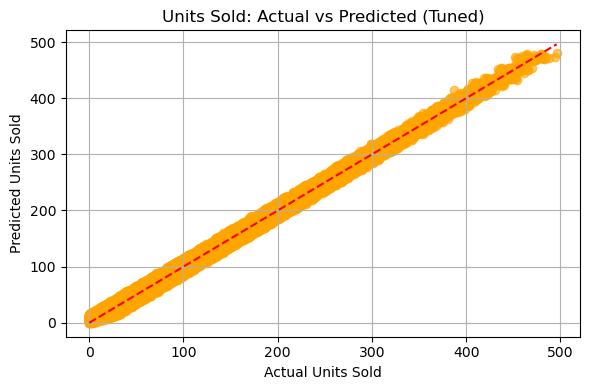

d:\Download\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Profit:
  R² Score: 1.00
  MAE: 366.85
  RMSE: 479.75
  MAPE: 6282015728937173.0000


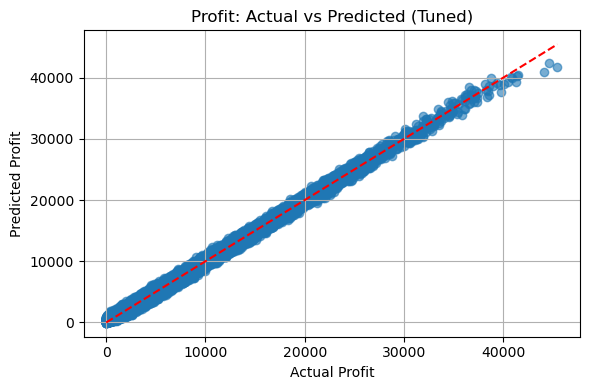

In [28]:
best_xgb_model_units = random_search_units.best_estimator_
print("\nBest XGBoost Parameters for Units Sold:", random_search_units.best_params_)
xgb_tuned_preds_units = best_xgb_model_units.predict(X_test)

best_xgb_model_profit = random_search_profit.best_estimator_
print("Best XGBoost Parameters for Profit:", random_search_profit.best_params_)
xgb_tuned_preds_profit = best_xgb_model_profit.predict(X_test)

print("\n--- Tuned XGBoost Evaluation Metrics ---")
# Units Sold
tuned_r2_units = r2_score(y_test_units, xgb_tuned_preds_units)
tuned_mae_units = mean_absolute_error(y_test_units, xgb_tuned_preds_units)
tuned_rmse_units = mean_squared_error(y_test_units, xgb_tuned_preds_units, squared=False)  # Corrected to compute RMSE
tuned_mape_units = mean_absolute_percentage_error(y_test_units, xgb_tuned_preds_units)  # Added MAPE
print("Units Sold:")
print(f"  R² Score: {tuned_r2_units:.2f}")
print(f"  MAE: {tuned_mae_units:.2f}")
print(f"  RMSE: {tuned_rmse_units:.2f}")
print(f"  MAPE: {tuned_mape_units:.4f}")

# Scatter plot for Units Sold
plt.figure(figsize=(6, 4))
plt.scatter(y_test_units, xgb_tuned_preds_units, alpha=0.6, color='orange')
plt.plot([y_test_units.min(), y_test_units.max()], [y_test_units.min(), y_test_units.max()], 'r--')
plt.xlabel("Actual Units Sold")
plt.ylabel("Predicted Units Sold")
plt.title("Units Sold: Actual vs Predicted (Tuned)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Profit
tuned_r2_profit = r2_score(y_test_profit, xgb_tuned_preds_profit)
tuned_mae_profit = mean_absolute_error(y_test_profit, xgb_tuned_preds_profit)
tuned_rmse_profit = mean_squared_error(y_test_profit, xgb_tuned_preds_profit, squared=False)  # Corrected to compute RMSE
tuned_mape_profit = mean_absolute_percentage_error(y_test_profit, xgb_tuned_preds_profit)  # Added MAPE
print("Profit:")
print(f"  R² Score: {tuned_r2_profit:.2f}")
print(f"  MAE: {tuned_mae_profit:.2f}")
print(f"  RMSE: {tuned_rmse_profit:.2f}")
print(f"  MAPE: {tuned_mape_profit:.4f}")

# Scatter plot for Profit
plt.figure(figsize=(6, 4))
plt.scatter(y_test_profit, xgb_tuned_preds_profit, alpha=0.6)
plt.plot([y_test_profit.min(), y_test_profit.max()], [y_test_profit.min(), y_test_profit.max()], 'r--')
plt.xlabel("Actual Profit")
plt.ylabel("Predicted Profit")
plt.title("Profit: Actual vs Predicted (Tuned)")
plt.grid(True)
plt.tight_layout()
plt.show()

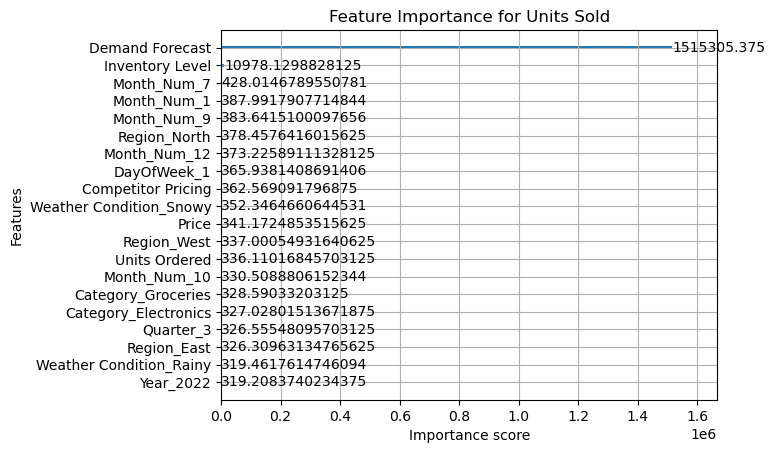

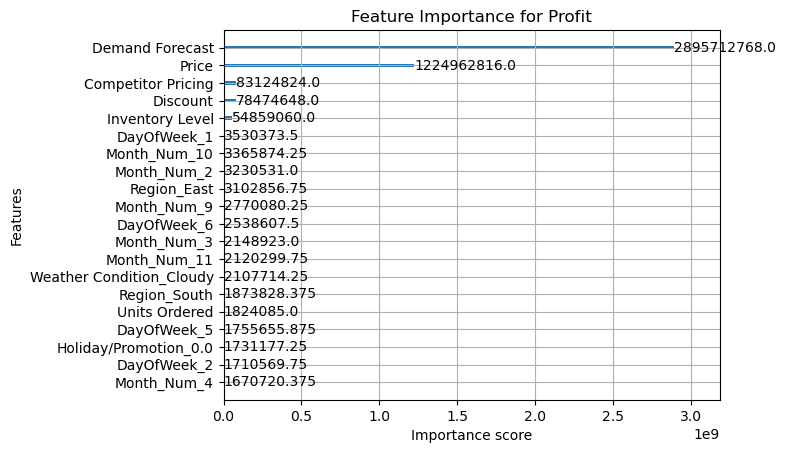

In [15]:
xgb.plot_importance(best_xgb_model_units, importance_type='gain', max_num_features=20)
plt.title("Feature Importance for Units Sold")
plt.show()

xgb.plot_importance(best_xgb_model_profit, importance_type='gain', max_num_features=20)
plt.title("Feature Importance for Profit")
plt.show()


## Prophet Model

In [16]:
!pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   -----------------

In [18]:
!pip install optuna


In [19]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import optuna
from statsmodels.graphics.tsaplots import plot_acf

def prepare_data(df):
    df_agg = df.groupby('Date')['Units Sold'].sum().reset_index()
    df_agg.rename(columns={'Date': 'ds', 'Units Sold': 'y'}, inplace=True)

    #split (80/20)
    split_index = int(len(df_agg) * 0.8)
    train = df_agg.iloc[:split_index]
    test = df_agg.iloc[split_index:]
    return train, test

train_agg, test_agg = prepare_data(df_ml)

In [20]:
# Baseline Model
def train_baseline(train_data):
    model = Prophet()
    model.fit(train_data)
    return model

baseline_model = train_baseline(train_agg)

20:03:07 - cmdstanpy - INFO - Chain [1] start processing
20:03:07 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
# Model Tuning

def tune_prophet(train_data, test_length, n_trials=30):
    def objective(trial):
        params = {
            'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5),
            'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 50),
            'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
            'yearly_seasonality': trial.suggest_categorical('yearly_seasonality', [True, False]),
            'weekly_seasonality': trial.suggest_categorical('weekly_seasonality', [True, False]),
            'daily_seasonality': False
        }

        model = Prophet(**params)
        model.fit(train_data)
        future = model.make_future_dataframe(periods=test_length)
        forecast = model.predict(future)
        preds = forecast.iloc[-test_length:]['yhat'].values
        return mean_absolute_error(test_agg['y'], preds)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    return study.best_params

best_params = tune_prophet(train_agg, len(test_agg))
tuned_model = Prophet(**best_params)
tuned_model.fit(train_agg)

[I 2025-05-12 20:23:20,431] A new study created in memory with name: no-name-a744c5b6-c9d5-499f-9e01-dd2a466d15a9
20:23:20 - cmdstanpy - INFO - Chain [1] start processing
20:23:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-05-12 20:23:20,884] Trial 0 finished with value: 921.7829057683825 and parameters: {'changepoint_prior_scale': 0.4183532941559254, 'seasonality_prior_scale': 29.571435511351304, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 0 with value: 921.7829057683825.
20:23:21 - cmdstanpy - INFO - Chain [1] start processing
20:23:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-05-12 20:23:21,298] Trial 1 finished with value: 864.1525674019986 and parameters: {'changepoint_prior_scale': 0.13318942934181963, 'seasonality_prior_scale': 5.476277038869825, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 1 with value: 864.1525674019986.
20:23:21 - cmdst


=== Baseline Model ===


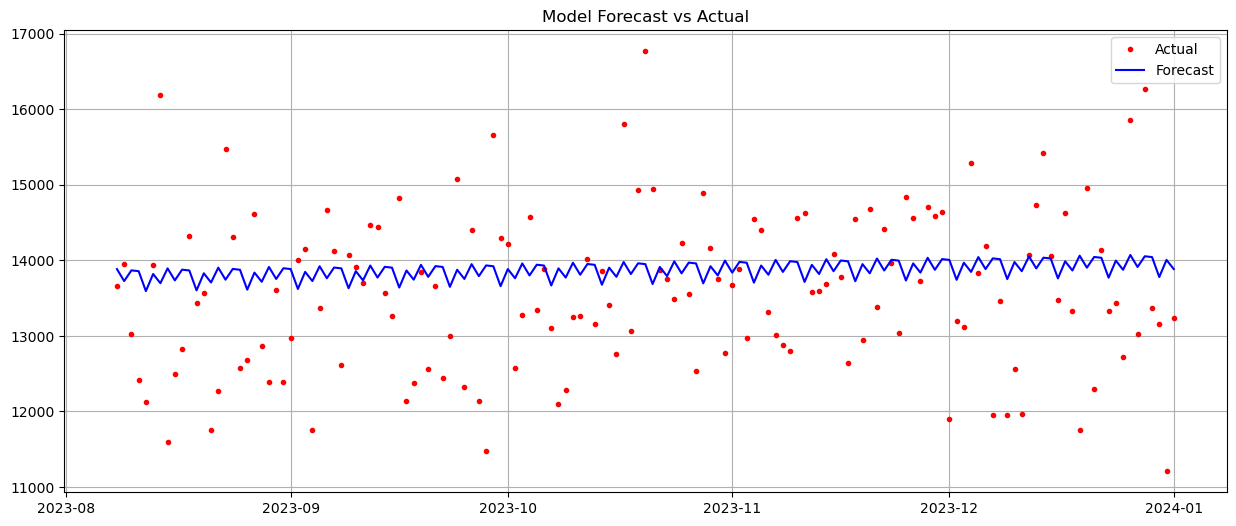

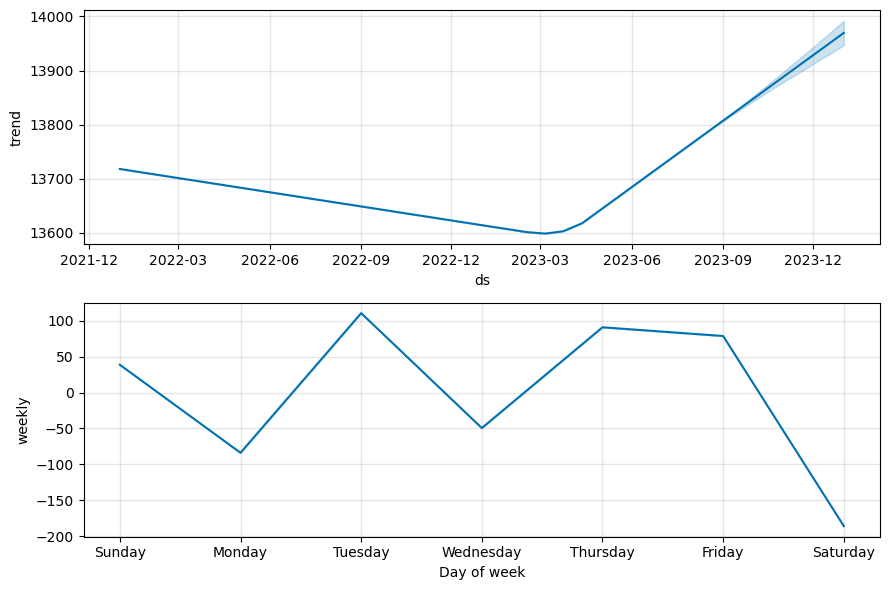


=== Tuned Model ===


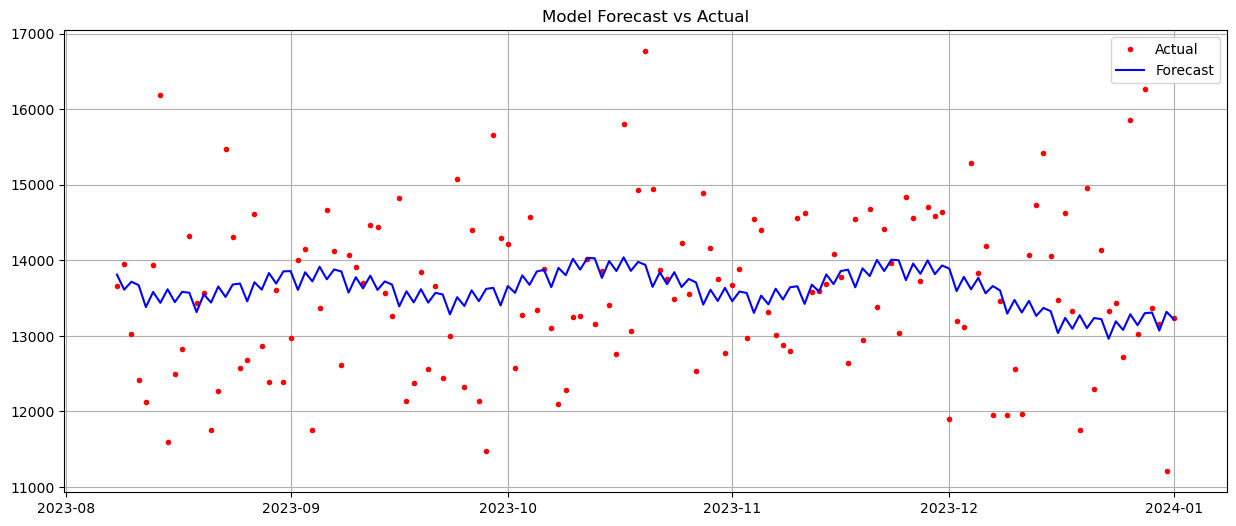

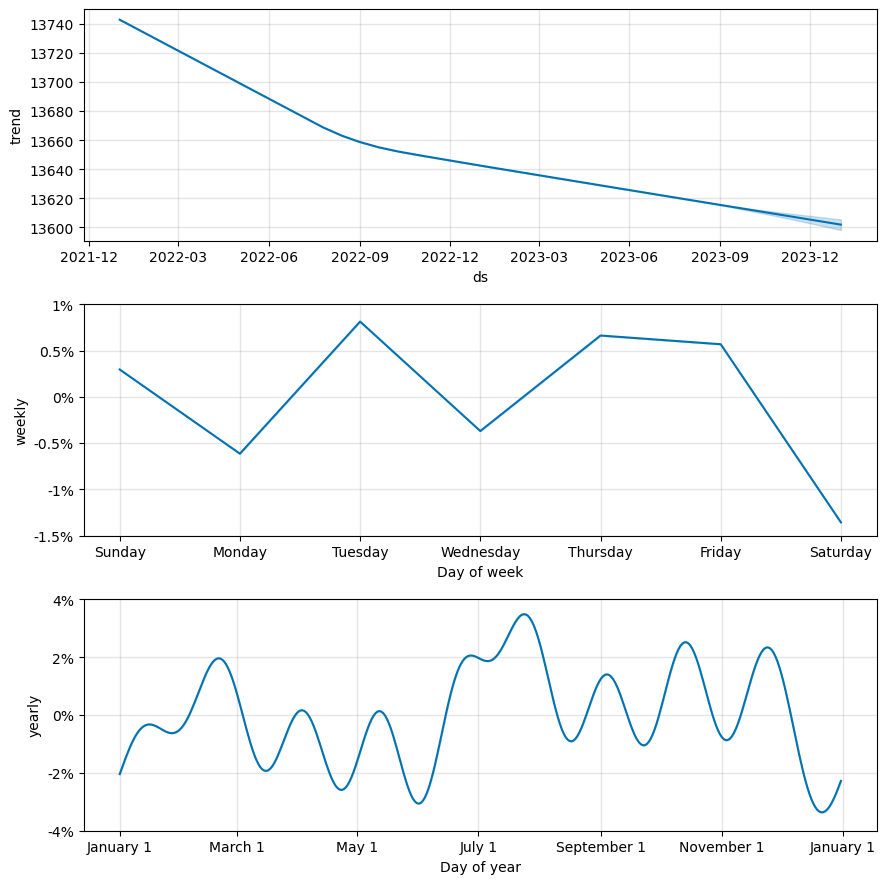

In [24]:
# Model Evaluation

def evaluate_model(model, train_data, test_data):
    future = model.make_future_dataframe(periods=len(test_data))
    forecast = model.predict(future)
    preds = forecast.iloc[-len(test_data):]['yhat'].values

    metrics = {
        'MAE': mean_absolute_error(test_data['y'], preds),
        'RMSE': np.sqrt(mean_squared_error(test_data['y'], preds)),
        'MAPE': mean_absolute_percentage_error(test_data['y'], preds)
    }
    plt.figure(figsize=(15, 6))
    plt.plot(test_data['ds'], test_data['y'], 'r.', label='Actual')
    plt.plot(test_data['ds'], preds, 'b-', label='Forecast')
    plt.title(f"Model Forecast vs Actual")
    plt.legend()
    plt.grid(True)
    plt.show()

    model.plot_components(forecast)
    plt.show()

    return metrics, preds

print("\n=== Baseline Model ===")
baseline_metrics, baseline_preds = evaluate_model(baseline_model, train_agg, test_agg)

print("\n=== Tuned Model ===")
tuned_metrics, tuned_preds = evaluate_model(tuned_model, train_agg, test_agg)


Baseline Model Residuals:


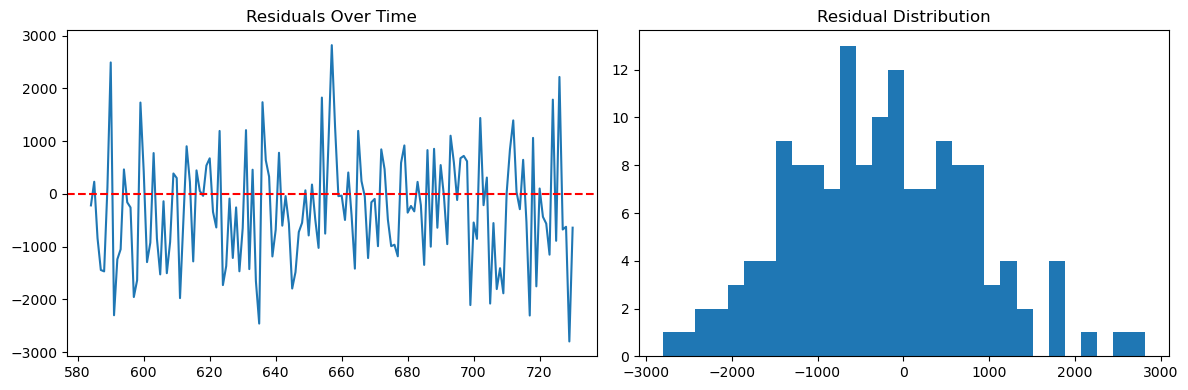

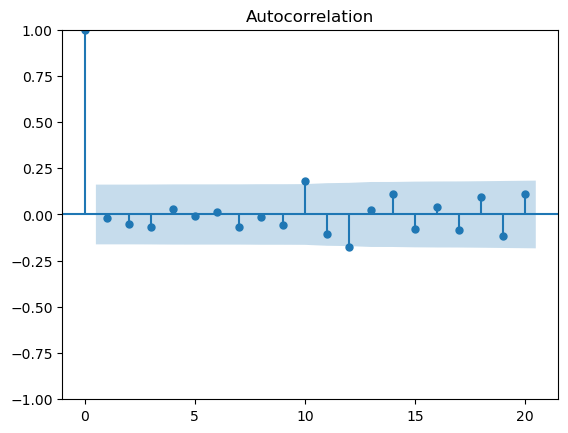


Tuned Model Residuals:


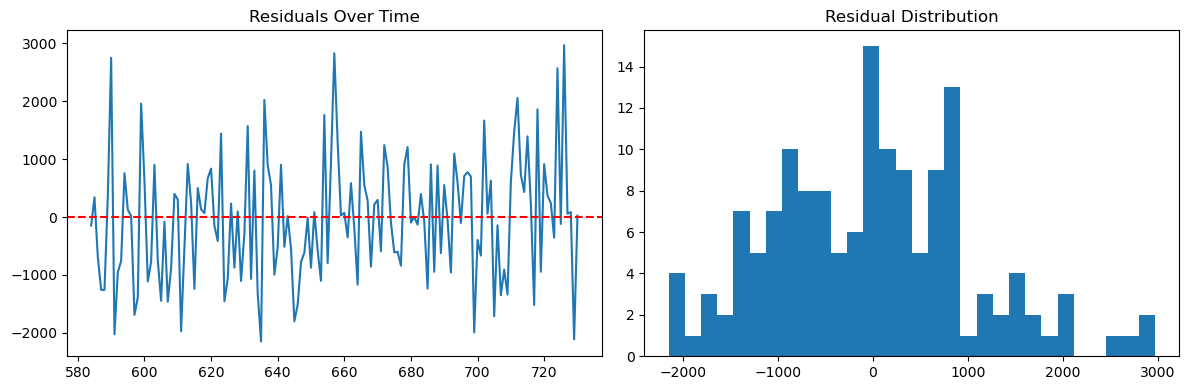

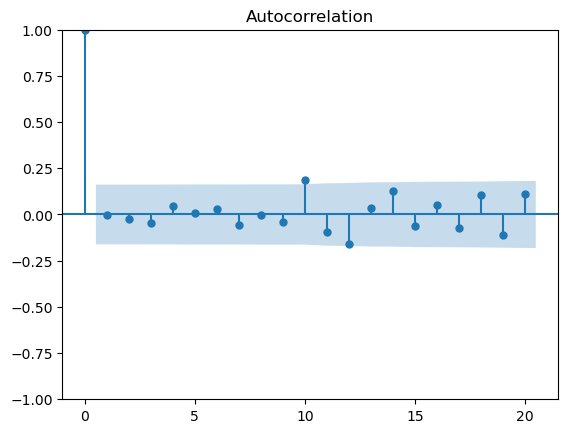

In [25]:
# Residual Analysis

def analyze_residuals(true_values, pred_values):
    residuals = true_values - pred_values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(residuals)
    plt.title("Residuals Over Time")
    plt.axhline(0, color='r', linestyle='--')

    plt.subplot(1, 2, 2)
    plt.hist(residuals, bins=30)
    plt.title("Residual Distribution")
    plt.tight_layout()
    plt.show()
    plot_acf(residuals, lags=20)
    plt.show()

print("\nBaseline Model Residuals:")
analyze_residuals(test_agg['y'], baseline_preds)

print("\nTuned Model Residuals:")
analyze_residuals(test_agg['y'], tuned_preds)

In [26]:
#Results comparison
results = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE'],
    'Baseline': [baseline_metrics['MAE'], baseline_metrics['RMSE'], baseline_metrics['MAPE']],
    'Tuned': [tuned_metrics['MAE'], tuned_metrics['RMSE'], tuned_metrics['MAPE']],
    'Improvement %': [
        ((baseline_metrics['MAE'] - tuned_metrics['MAE']) / baseline_metrics['MAE'] * 100),
        ((baseline_metrics['RMSE'] - tuned_metrics['RMSE']) / baseline_metrics['RMSE'] * 100),
        ((baseline_metrics['MAPE'] - tuned_metrics['MAPE']) / baseline_metrics['MAPE'] * 100)
    ]
})

print("\n=== Model Comparison ===")
print(results.round(2))


=== Model Comparison ===
  Metric  Baseline    Tuned  Improvement %
0    MAE    880.16   844.93           4.00
1   RMSE   1089.54  1061.37           2.59
2   MAPE      0.07     0.06           5.78


## LSTM Model

In [29]:
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential

In [31]:
df_ml = df_ml.sort_values('Date')

daily_sales = df_ml.groupby('Date')['Units Sold'].sum().reset_index()
daily_sales.set_index('Date', inplace=True)

In [32]:
# Feature engineering
daily_sales['DayOfWeek'] = daily_sales.index.dayofweek
daily_sales['Month'] = daily_sales.index.month

In [33]:
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(daily_sales)

In [34]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 0])  # Target is 'Units Sold'
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(sales_scaled, seq_length)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
input_shape = (seq_length, X.shape[2])

model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=input_shape),
    Dropout(0.2),
    LSTM(100, activation='relu'),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])

d:\Download\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [44]:
# creates an optimizer object of the Adam type, which is a popular optimization algorithm for training neural networks.
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

lstm_predictions = model.predict(X_test)
lstm_predictions_full = np.column_stack((lstm_predictions, np.zeros((lstm_predictions.shape[0], X.shape[2] - 1))))
y_test_full = np.column_stack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X.shape[2] - 1))))

lstm_predictions_inverse = scaler.inverse_transform(lstm_predictions_full)[:, 0]
y_test_actual_inverse = scaler.inverse_transform(y_test_full)[:, 0]
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual_inverse, lstm_predictions_inverse))
lstm_mae = mean_absolute_error(y_test_actual_inverse, lstm_predictions_inverse)
lstm_mape= mean_absolute_percentage_error(y_test_actual_inverse, lstm_predictions_inverse)

print("LSTM RMSE:", lstm_rmse)
print("LSTM MAE:", lstm_mae)
print("LSTM MAPE : ",lstm_mape)

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0264 - val_loss: 0.0218
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0316 - val_loss: 0.0221
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0260 - val_loss: 0.0218
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0294 - val_loss: 0.0231
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0272 - val_loss: 0.0232
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0260 - val_loss: 0.0230
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0283 - val_loss: 0.0228
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0265 - val_loss: 0.0220
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0269 - val_loss: 0.0222
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0264 - val_loss: 0.0220
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0247 - val_loss: 0.0245
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step WARNING:tensor

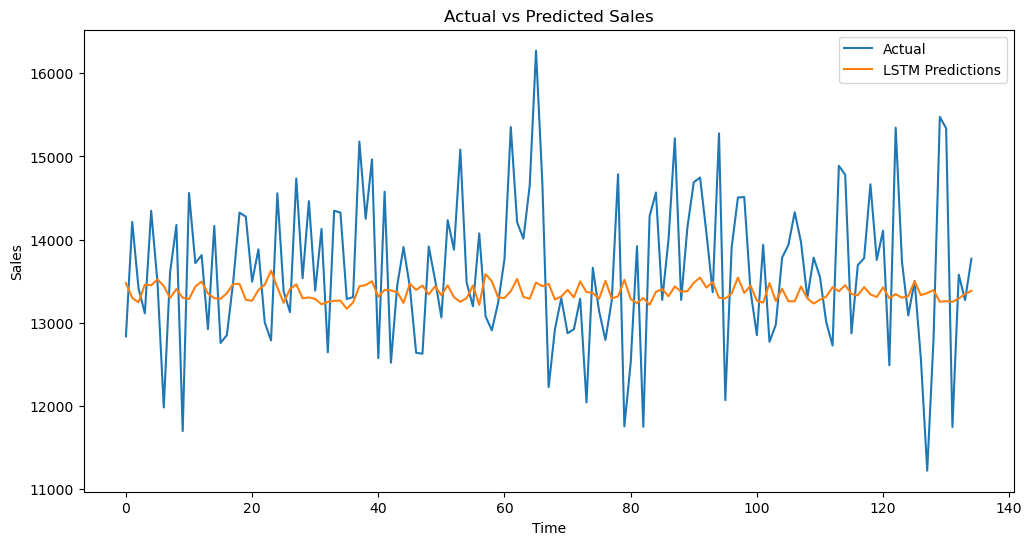

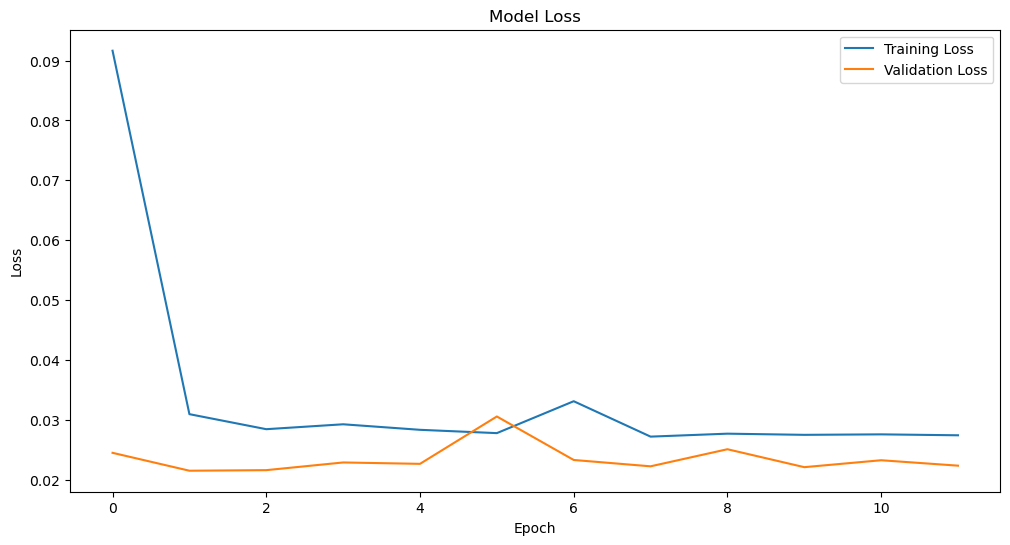

In [37]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual_inverse, label='Actual')
plt.plot(lstm_predictions_inverse, label='LSTM Predictions')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

RMSE and MAE values around 922 and 732 respectively may indicate reasonable (moderate) predictive accuracy , continuous improvement through experimentation and validation is always beneficial.

Initial Loss: The initial loss value (0.1203) is relatively high, indicating that the model initially struggled to make accurate predictions

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Prophet prediction (adjust based on how you named your variables)
future_df = tuned_model.make_future_dataframe(periods=len(test_agg))
prophet_forecast = tuned_model.predict(future_df)
prophet_pred = prophet_forecast['yhat'].values[:len(test_agg)]

# Prophet true values
prophet_true = test_agg['y'].values


# Collect results
results = {
    'XGBoost': {
        'RMSE': tuned_rmse_units,
        'MAE': tuned_mae_units,
        'MAPE': tuned_mape_units
    },
    'LSTM': {
        'RMSE': lstm_rmse,
        'MAE': lstm_mae,
        'MAPE': lstm_mape,
    },
    'Prophet': {
        'RMSE': prophet_rmse,
        'MAE': prophet_mae,
        'MAPE':  ((baseline_metrics['MAPE'] - tuned_metrics['MAPE']) / baseline_metrics['MAPE'] * 100)
    
    }
}

# Print comparison table
print("📊 Model Comparison (based on Units Sold prediction):")
for model_name, metrics in results.items():
    print(f"\n🔸 {model_name}")
    print(f"  RMSE: {metrics['RMSE']:.2f}")
    print(f"  MAE: {metrics['MAE']:.2f}")

    print(f"  MAPE: {metrics['MAPE']:.4f}")

# Select best model based on RMSE
best_model_name = min(results, key=lambda name: results[name]['RMSE'])
print(f"\n✅ Best model based on RMSE: {best_model_name}")

📊 Model Comparison (based on Units Sold prediction):

🔸 XGBoost
  RMSE: 8.52
  MAE: 7.27
  MAPE: 131514132154745.2812

🔸 LSTM
  RMSE: 949.88
  MAE: 752.01
  MAPE: 0.0544

🔸 Prophet
  RMSE: 1092.74
  MAE: 873.09
  MAPE: 5.7761

✅ Best model based on RMSE: XGBoost
